# Projet IA HumanForYou


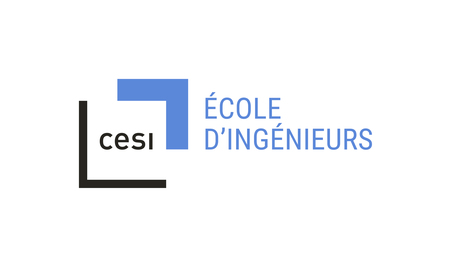

|Auteur|
|---|
|Victor Massotte|
|Quentin Butel|
|Lyna Selam|
|Arthur Oliveira|
|Guillaume Langlois|

## Contexte

La direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

## Ethique

Une intelligence artificielle est dite éthique lorsque sa conception, sa construction et son utilisation est centrée sur l'éthique humaine.

### Conception

Avant de commencer le développement (ou la construction) de notre intelligence artificielle, il faut déterminer quels sont les caractéristiques pouvant être utilisés tout en respectant les notions d'éthique suivantes : 

- La liberté humaine : Un être humain est libre de faire ses propres choix.
- La dignité humaine : Un être humain doit être considéré comme une fin en soi et non comme un moyen, c'est-à-dire que l'on ne peut pas rabattre un être humain à un simple objet.
- L'autonomie humaine : Elle est définie comme la capacité du sujet à décider pour lui-même des règles auxquelles il obéit, et à agir en conséquence.
- La protection de la vie privée et des données : vise à réglementer l’utilisation et le traitement des données personnelles que nous respectons via la confidentialité des données assuré par :
    - L’anonymat : Aucun employé n’est nommé ou ne peut être rattaché à notre jeu de données. 
    - La synthétisation : Nous avons recréé des données à partir de la réalité. 
- La non-discrimination et l'égalité : Principe interdisant de traiter moins favorablement une personne en se basant sur des critères réel ou supposé comme l'apparence, la croyance, l'âge ou le sexe pour se rapprocher d’une égalité de traitement.
- La diversité : hétérogénéité
- L'équité : Principe impliquant le respect absolu de ce qui est dû à chacun ou de l’égalité des chances. Il vise à instaurer une égalité de droit, en tenant compte des inégalités de fait.

Nous avons déterminé pour chaque caractéristique si ce dernier est éthique ou non dans notre cadre d'étude en se basant sur les critères mentionnés ci-dessus :

|Caractéristique|Description|Ethique|
|:-|:-|:-|
|Age|L'âge de l'employé en 2015|OUI
|Attrition|Est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?|OUI
|BusinessTravel|A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ?|OUI
|DistanceFromHome|Distance en km entre le logement de l'employé et l'entreprise|OUI
|Education|Niveau d'étude|OUI
|EducationField|Domaine d'étude, matière principale|OUI
|EmployeeCount|L'employé était compté dans les effectifs en 2015|OUI
|EmployeeId|Identifiant de l'employé|OUI
|<span style="color: red">Gender</span>|<span style="color: red">Sexe de l'employé</span>|<span style="color: red">NON</span>
|JobLevel|Niveau hiérarchique dans l'entreprise|OUI
|JobRole|Métier dans l'entreprise|OUI
|MaritalStatus|Statut marital du salarié|OUI
|MonthlyIncome|Salaire brut en roupie/mois|OUI
|NumCompaniesWorked|Nombre d'entreprises pour lequel l'employé a travaillé avant de rejoindre HumanForYou|OUI
|Over18|Est-ce que le salarié a plus de 18 ans ou non ?|OUI
|PercentSalaryHike|% d'augmentation salaire en 2015|OUI
|StandardHours|Nombre d'heures/jour dans le contrat du salarié|OUI
|<span style="color: red; width: 100%">StockOptionLevel</span>|<span style="color: red"> Niveau d'investissement en actions de l'entreprise par le salarié</span>|<span style="color: red">NON</span>
|TotalWorkingYears|Nombre d'années d'expérience en entreprise du salarié pour le même type de poste|OUI
|TrainingTimesLastYear|Nombre de jour de formation en 2015|OUI
|YearsAtCompany|Ancienneté dans l'entreprise|OUI
|YearsSinceLastPromotion|Nombre d'années depuis la dernière augmentation individuelle|OUI
|YearsWithCurrentManager|Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé|OUI
|JobInvolvement|Evaluation de son implication dans son travail par son manager|OUI
|PerformanceRating|Evaluation de son niveau de performance annuel pour l'entreprise par son manager|OUI
|EnvironmentSatisfaction|Evaluation de l'environnement de travail par l'employé|OUI
|JobSatisfaction|Evaluation de son travail par l'employé|OUI
|WorkLifeBalance|Evaluation sur l'équilibre entre vie privé et vie professionnelle  par l'employé|OUI
|in|Heure d'arrivée|OUI
|out|Heure de départ|OUI  

<i>Nous considérons les critères en <span style="color:red;">rouge</span> comme non éthique par rapport à notre situation.</i>

#### Nous devons également répondre aux questions de la Commission Européenne :

<i>Le système d'IA est-il potentiellement discriminatoire à l'encontre des personnes sur la base de des motifs suivants (liste non exhaustive) : sexe, race, couleur, origine ethnique ou sociale, génétique caractéristiques, langue, religion ou conviction, opinion politique ou toute autre opinion, appartenance à une minorité, fortune, naissance, handicap, âge ou orientation sexuelle ?</i>

<strong>Oui, car ce genre de données ne peuvent pas changer, donc l’IA prend en compte le sexe et l’âge.</strong>

<i>Avez-vous mis en place des processus pour tester et surveiller la discrimination négative potentielle (préjugé) pendant les phases de développement, de déploiement et d'utilisation du système d'IA ?</i>

<strong>Oui, notre IA test et surveille la discrimination négative potentielle.</strong>

<i>Avez-vous mis en place des processus pour traiter et rectifier la discrimination négative potentielle (préjugé) dans le système d'IA ?</i>

<strong>Oui, des processus ont été mis en place pour traiter et rectifier la discrimination négative potentielle.</strong>

<i>Le système AI respecte-t-il les droits de l'enfant, par exemple en ce qui concerne protection et en tenant compte de l'intérêt supérieur de l'enfant ?</i>

<strong>Oui, notre IA ne traite aucune donnée relative a des personnes mineures.</strong>

<i>Avez-vous mis en place des processus pour traiter et rectifier les dommages potentiels causés aux enfants par l'IA système?</i>

<strong>Oui, puisque nous n’avons pas d’enfants.</strong>

<i>Avez-vous mis en place des processus pour tester et surveiller les dommages potentiels aux enfants pendant la phase de développement, de déploiement et d'utilisation du système d'IA ?</i>

<strong>Oui, puisque nous n’avons pas d’enfants.</strong>

<i>Le système d'IA protège-t-il les données personnelles relatives aux individus conformément au RGPD ?</i>

<strong>Oui, notre système d’IA protège les données personnelles et relative au individu.</strong>

<i>Avez-vous mis en place des processus pour évaluer en détail la nécessité d'un impact sur la protection des données évaluation, y compris une évaluation de la nécessité et de la proportionnalité du traitement opérations par rapport à leur finalité, en ce qui concerne les phases de développement, de déploiement et d'utilisation du système d'IA ?</i>

<strong>Oui, des processus ont été mis en place pour évaluer la nécessité d’un impact sur la protection des données.</strong>

<i>Avez-vous mis en place les mesures envisagées pour faire face aux risques, y compris les sauvegardes, la sécurité des mesures et des mécanismes pour assurer la protection des données personnelles à l'égard de la phase de développement, de déploiement et d'utilisation du système d'IA ?</i>

<strong>Oui, nous utilisons la plateforme Github qui facilite le déploiement et la sauvegarde du projet ainsi que des données et demande une invitation de la part de l'administrateur du projet pour pouvoir accéder à l'algorithme.</strong>

<i>Le système AI respecte-t-il la liberté d'expression et d'information et/ou la liberté d’assemblée et association ?</i>

<strong>Oui, car toutes les données collectées ont été donné par choix, les employés étaient libres d’y répondre ou pas et savaient que les données allaient être utilisées.</strong>

### Construction

Il ne suffit pas d'avoir des données éthiques pour que notre IA le soit. En effet, la construction de notre IA doit répondre à une certaine norme de <strong>sécurité</strong> et de <strong>robustesse</strong>.

La robustesse et la sécurité d’une IA correspond à sa faculté à accumuler des cas d’utilisations variées. Nous savons qu’une IA dois apprendre avec un jeu de donnée conséquent. Cependant si chaque cas d’utilisation est dans les meilleur condition pour celle-ci, elle apprendra mais seulement des cas simples et non des cas complexe qu'elle ne saura pas résoudre. 

Nous pouvons prendre pour exemple l’apprentissage de la conduite. Il est vrai que circuler quand il n’y a aucun usager de la route à nos coté est très simple mais lorsque nous allons sur Paris avec énormément de trafic c’est beaucoup plus complexe de s’en sortir. Pour une IA c’est le même principe. Il faut qu’elle apprenne le plus de cas d’utilisation possible pour apprendre correctement.

Il est vrai que l'apprentissage de la conduite en milieu rural est beaucoup plus simple qu'en milieu urbain où la circulation y est plus dense et les informations à prendre en compte plus nombreuses (piéton, feu tricolore, panneau de signalisation, différentes limitation de vitesse, etc ...).

Mais ce n'est pas tout puisqu'il faut faire attention au <strong>sur-apprentissage</strong>.

En intelligence artificielle, on parle de sur-apprentissage quand un modèle a trop appris les particularités de chacun des exemples fournis en exemple. Il présente alors un taux de succès très important sur les données d’entraînement, au détriment de ses performances générales réelles.

Voici un exemple ci-dessous où le modèle de gauche montre un modèle performant capable d'estimer de manière fiable la taille moyenne d'un homme en fonction de son age contrairement à la courbe de droite qui reproduit trop fidèlement les échantillons d'entrainement.

![ex_sur_apprentissage](https://www.actuia.com/wp-content/uploads/2018/10/apprentissage_surapprentiss.png)

### Utilisation

La complexité de l'IA est souvent mal représenté dû à l'hypermédiatisation, aux représentations faussées et à la science-fiction. Cette mécompréhension peut entraîner une certaine méfiance envers l'utilisation de cette technologie. Pour répondre à ce problème, il est nécessaire de fournir une explication complète et transparente du fonctionnement de cette dernière.

Pour cela, il faut décrire chaque étape du cycle de vie de l'IA de tel sorte que :

- Le processus doit être claire pour que l'utilisateur de l'IA soit en mesure de comprendre facilement chaque étape effectué.
- Les résultats fournis par chaque étapes pour qu'ils soient facilement interprétable, exploitable et puisse être contesté sur la base d'informations simples et faciles à comprendre sur les facteurs et la logique qui ont servi de base à notre prédiction.

##  1. Préparation des données

### A. Initialisation du projet

In [1]:
# imports
import numpy as np
import seaborn as sns
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### B. Importation

In [2]:
import os
import pandas as pd

dataSets_Path = os.path.join(".\datasets")

generalData = pd.read_csv(os.path.join(dataSets_Path, "general_data.csv"))
employeeData = pd.read_csv(os.path.join(dataSets_Path, "employee_survey_data.csv"))
managerData = pd.read_csv(os.path.join(dataSets_Path, "manager_survey_data.csv"))
csvInTimeData = pd.read_csv(os.path.join(dataSets_Path, "in_time.csv"))
csvOutTimeData = pd.read_csv(os.path.join(dataSets_Path, "out_time.csv"))

intTimeData = csvInTimeData.rename(columns={'Unnamed: 0': 'EmployeeID'})
outTimeData = csvOutTimeData.rename(columns={'Unnamed: 0': 'EmployeeID'})

In [3]:
allData = pd.merge(employeeData, generalData, how='inner', on=['EmployeeID'])
allData = allData.merge(managerData, how='inner', on=['EmployeeID'])

""" allData = allData.merge(intTimeData, how='inner', on=['EmployeeID'])
allData = allData.merge(outTimeData, how='inner', on=['EmployeeID']) """

allData.drop("EmployeeID", axis=1, inplace=True)
allData.drop("Over18", axis=1, inplace=True) 
allData.drop("EmployeeCount", axis=1, inplace=True) 
allData.drop("StandardHours", axis=1, inplace=True) 
allData.drop("MaritalStatus", axis=1, inplace=True) 
allData.drop("Gender", axis=1, inplace=True) 

Test = allData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EnvironmentSatisfaction  4385 non-null   float64
 1   JobSatisfaction          4390 non-null   float64
 2   WorkLifeBalance          4372 non-null   float64
 3   Age                      4410 non-null   int64  
 4   Attrition                4410 non-null   object 
 5   BusinessTravel           4410 non-null   object 
 6   Department               4410 non-null   object 
 7   DistanceFromHome         4410 non-null   int64  
 8   Education                4410 non-null   int64  
 9   EducationField           4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4391 non-null   float64
 14  PercentSalaryHike       

### C. Decode valeur

In [4]:
allData['PerformanceRating'] = allData['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
allData['EnvironmentSatisfaction'] = allData['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['JobSatisfaction'] = allData['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['JobInvolvement'] = allData['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['WorkLifeBalance'] = allData['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})
allData['Education'] = allData['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'})
allData['JobLevel'] = allData["JobLevel"].replace({ 1 : 'Apprentice', 2: 'Junior Employee',3: 'Employee',4: 'Manager',5 : 'Director'})
allData['StockOptionLevel'] = allData['StockOptionLevel'].replace({ 0 : 'Low', 1: 'Medium', 2: 'High', 3: 'Very Hight'})

In [5]:
allData.describe(include="all")

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,...,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
count,4385,4390,4372,4410.000000,4410,4410,4410,4410.000000,4410,4410,...,4391.000000,4410.000000,4410,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410,4410
unique,4,4,4,NaN,2,3,3,NaN,5,6,...,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,4,2
top,High,Very High,Better,NaN,No,Travel_Rarely,Research & Development,NaN,Bachelor,Life Sciences,...,NaN,NaN,Low,NaN,NaN,NaN,NaN,NaN,High,Excellent
freq,1350,1367,2660,NaN,3699,3129,2883,NaN,1716,1818,...,NaN,NaN,1893,NaN,NaN,NaN,NaN,NaN,2604,3732
mean,NaN,NaN,NaN,36.923810,NaN,NaN,NaN,9.192517,NaN,NaN,...,2.694830,15.209524,NaN,11.279936,2.799320,7.008163,2.187755,4.123129,NaN,NaN
std,NaN,NaN,NaN,9.133301,NaN,NaN,NaN,8.105026,NaN,NaN,...,2.498887,3.659108,NaN,7.782222,1.288978,6.125135,3.221699,3.567327,NaN,NaN
min,NaN,NaN,NaN,18.000000,NaN,NaN,NaN,1.000000,NaN,NaN,...,0.000000,11.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,30.000000,NaN,NaN,NaN,2.000000,NaN,NaN,...,1.000000,12.000000,NaN,6.000000,2.000000,3.000000,0.000000,2.000000,NaN,NaN
50%,NaN,NaN,NaN,36.000000,NaN,NaN,NaN,7.000000,NaN,NaN,...,2.000000,14.000000,NaN,10.000000,3.000000,5.000000,1.000000,3.000000,NaN,NaN
75%,NaN,NaN,NaN,43.000000,NaN,NaN,NaN,14.000000,NaN,NaN,...,4.000000,18.000000,NaN,15.000000,3.000000,9.000000,3.000000,7.000000,NaN,NaN


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>,
        <AxesSubplot:title={'center':'MonthlyIncome'}>],
       [<AxesSubplot:title={'center':'NumCompaniesWorked'}>,
        <AxesSubplot:title={'center':'PercentSalaryHike'}>,
        <AxesSubplot:title={'center':'TotalWorkingYears'}>],
       [<AxesSubplot:title={'center':'TrainingTimesLastYear'}>,
        <AxesSubplot:title={'center':'YearsAtCompany'}>,
        <AxesSubplot:title={'center':'YearsSinceLastPromotion'}>],
       [<AxesSubplot:title={'center':'YearsWithCurrManager'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

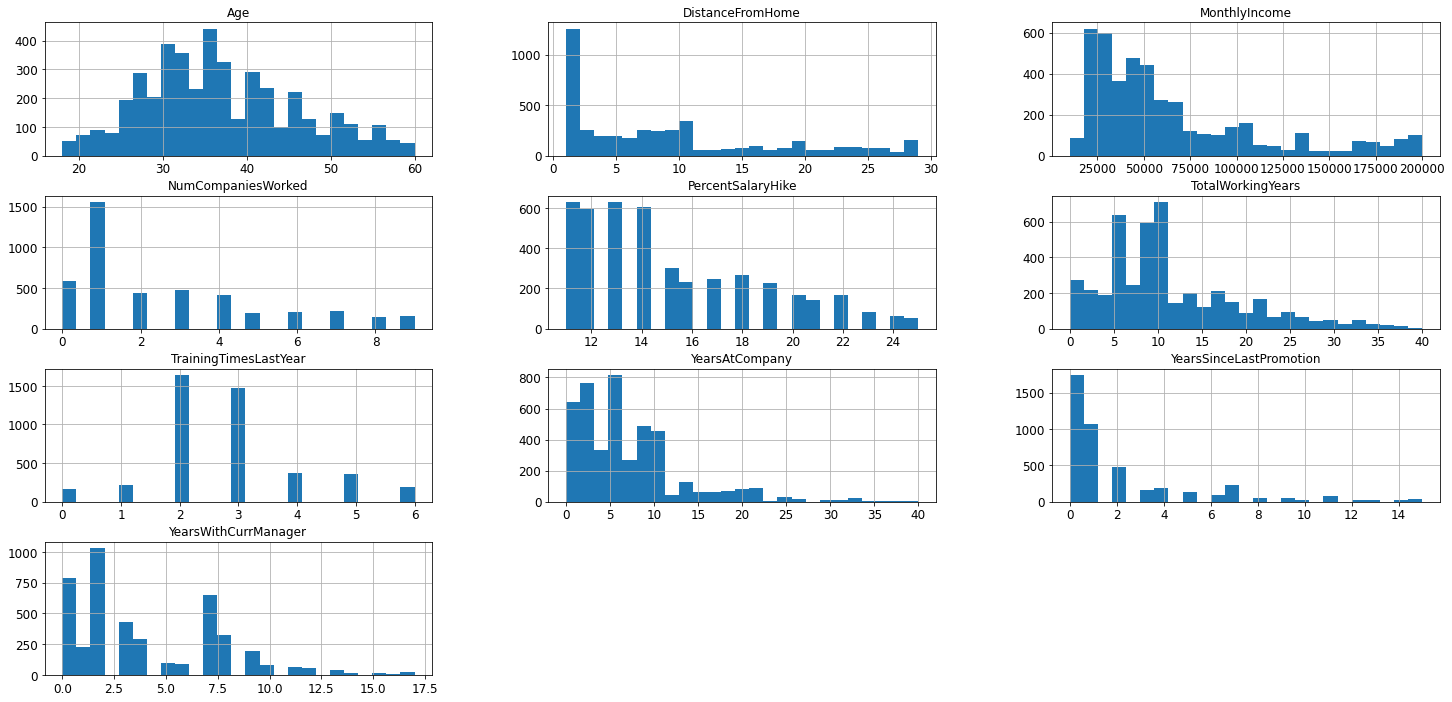

In [6]:
allData.hist(figsize=(25,12), bins=25,column=list(allData.columns))

##  2. Pré-traitement des données


### A. Analyse des variables



#### Analyse de toutes les variables qualitatives

Vous trouverez en dessous tous les graphes avec les variables de type `object` du jeu de données.

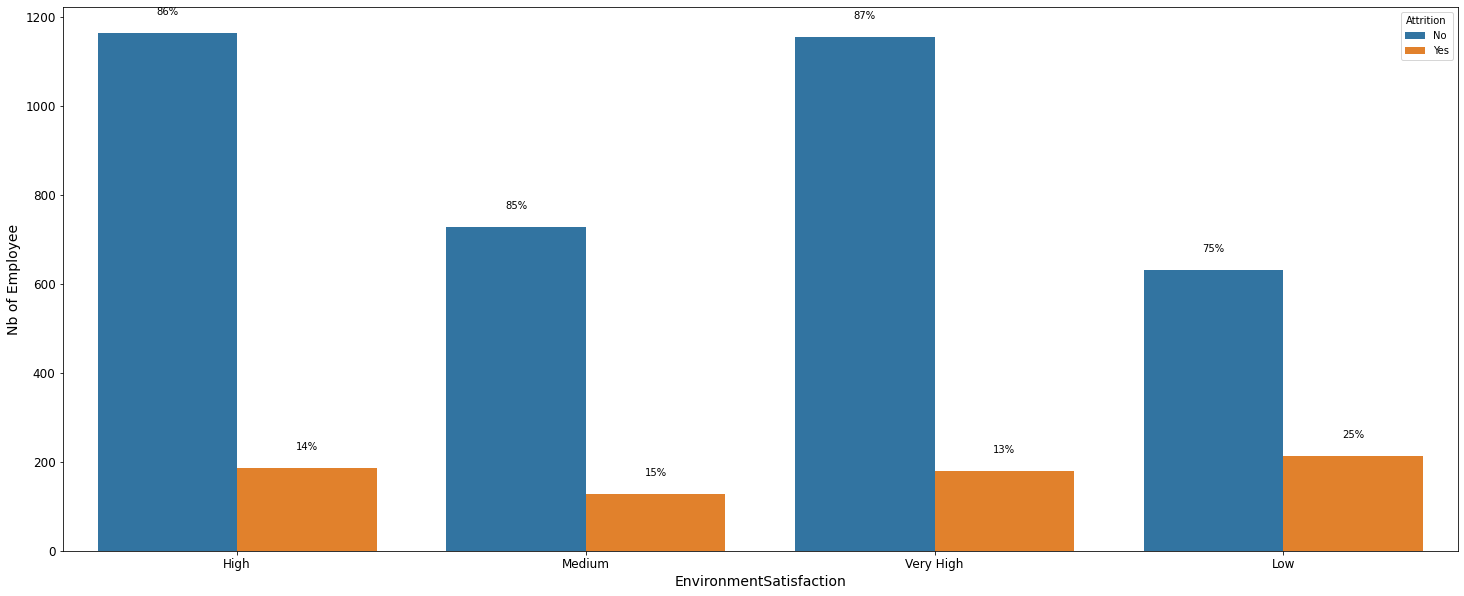

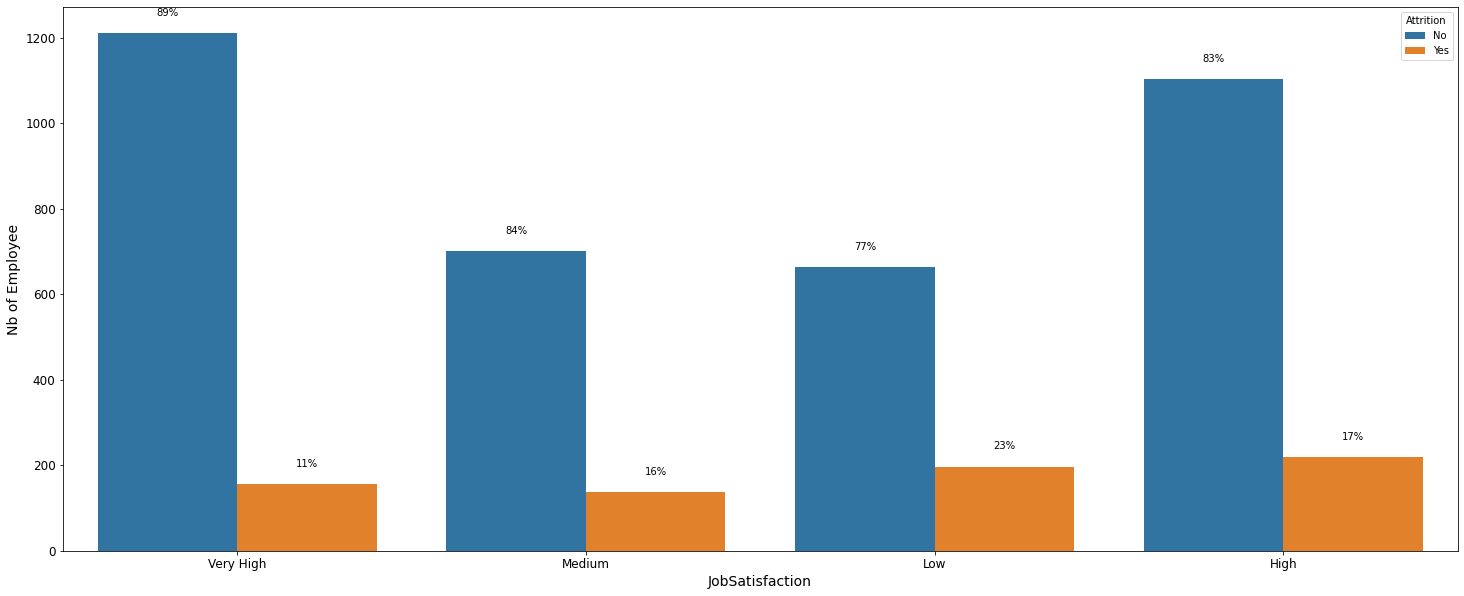

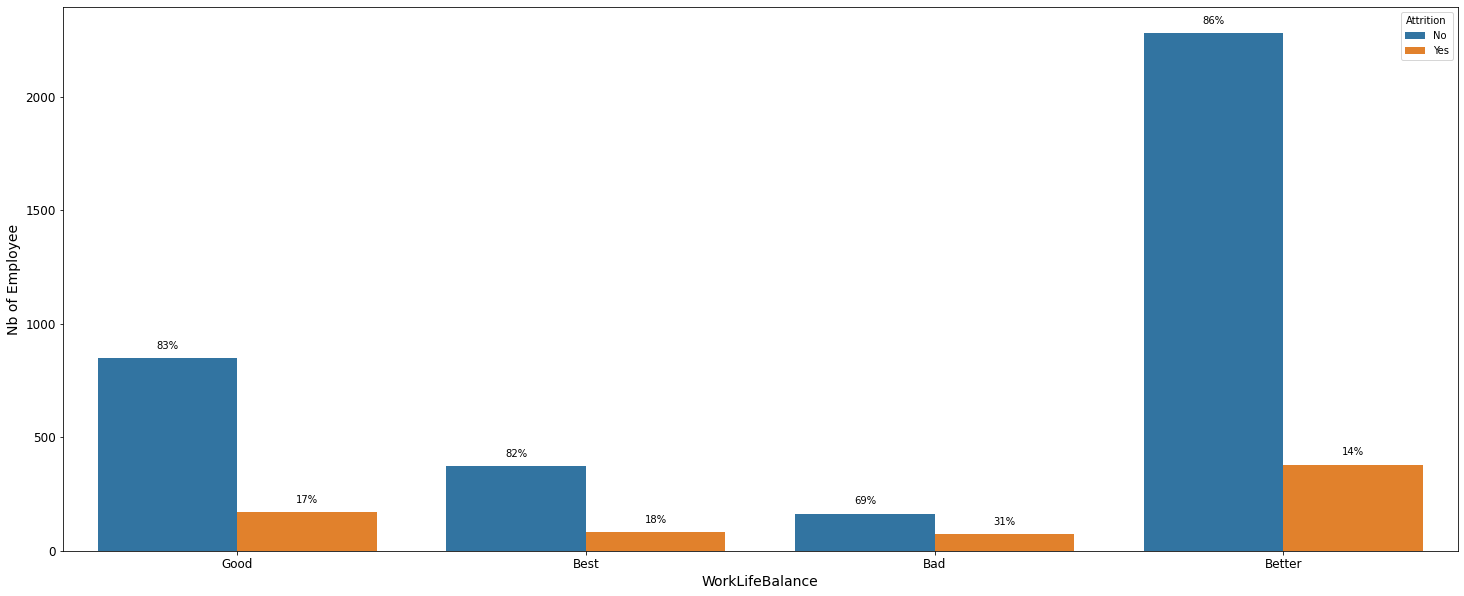

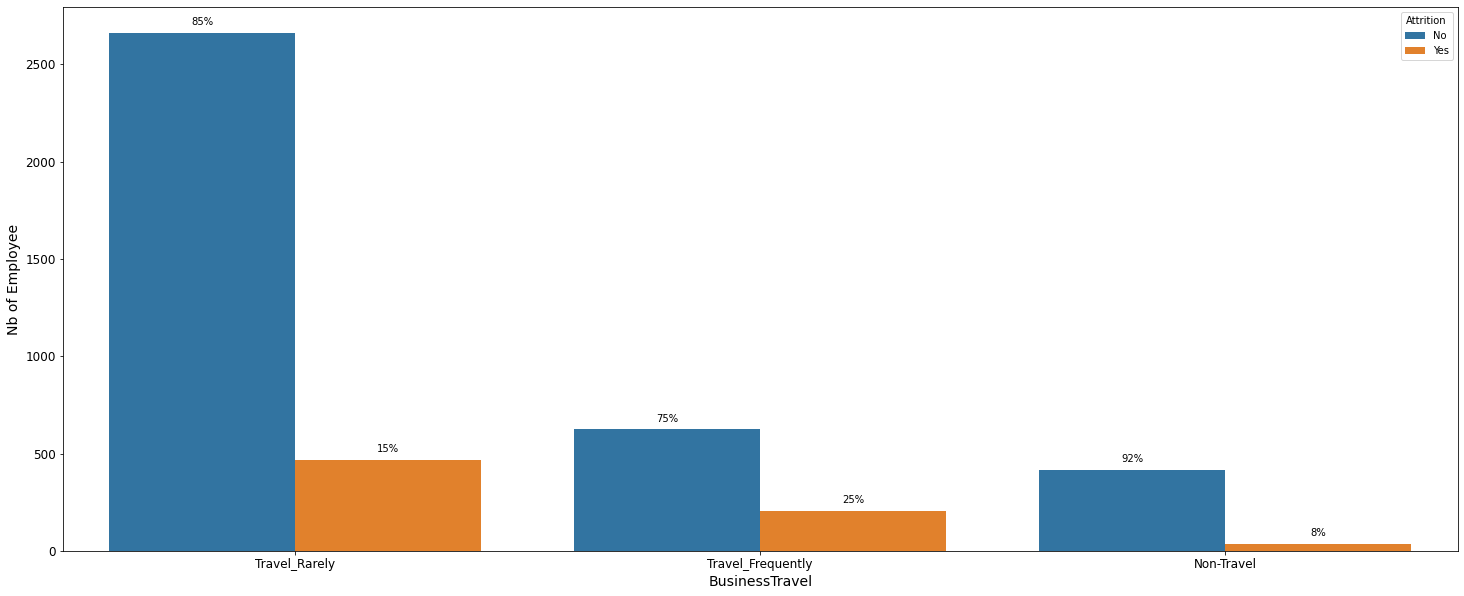

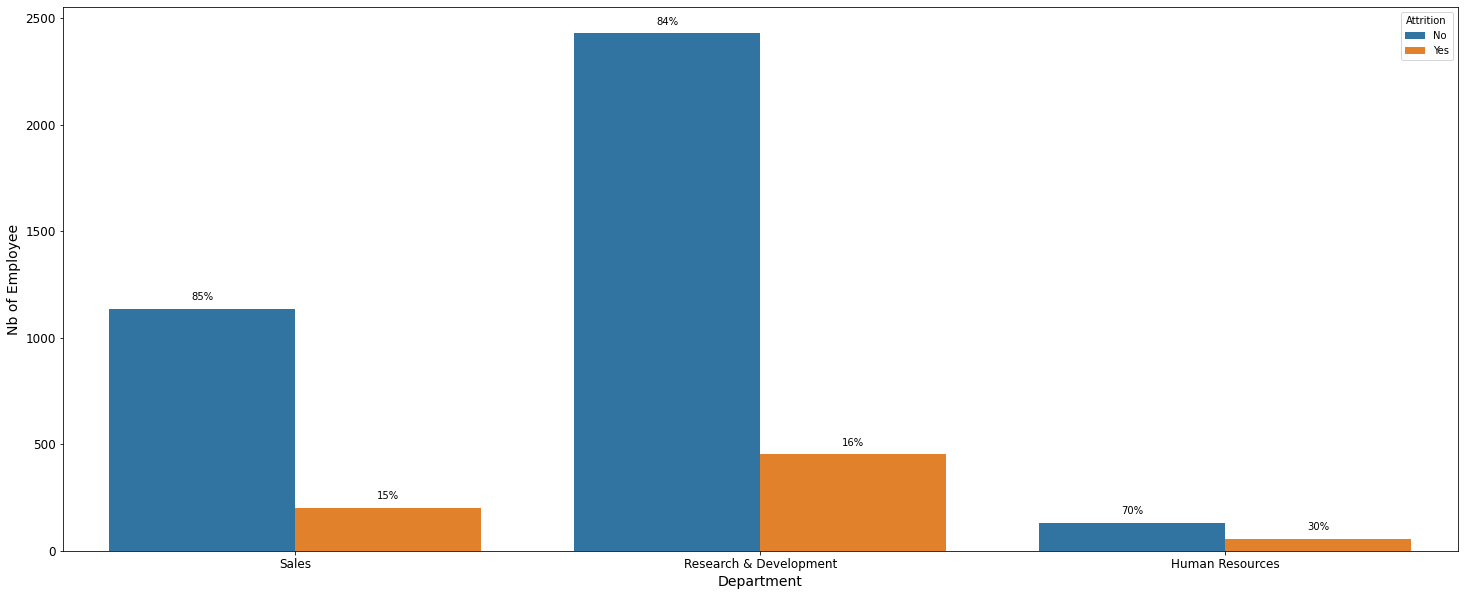

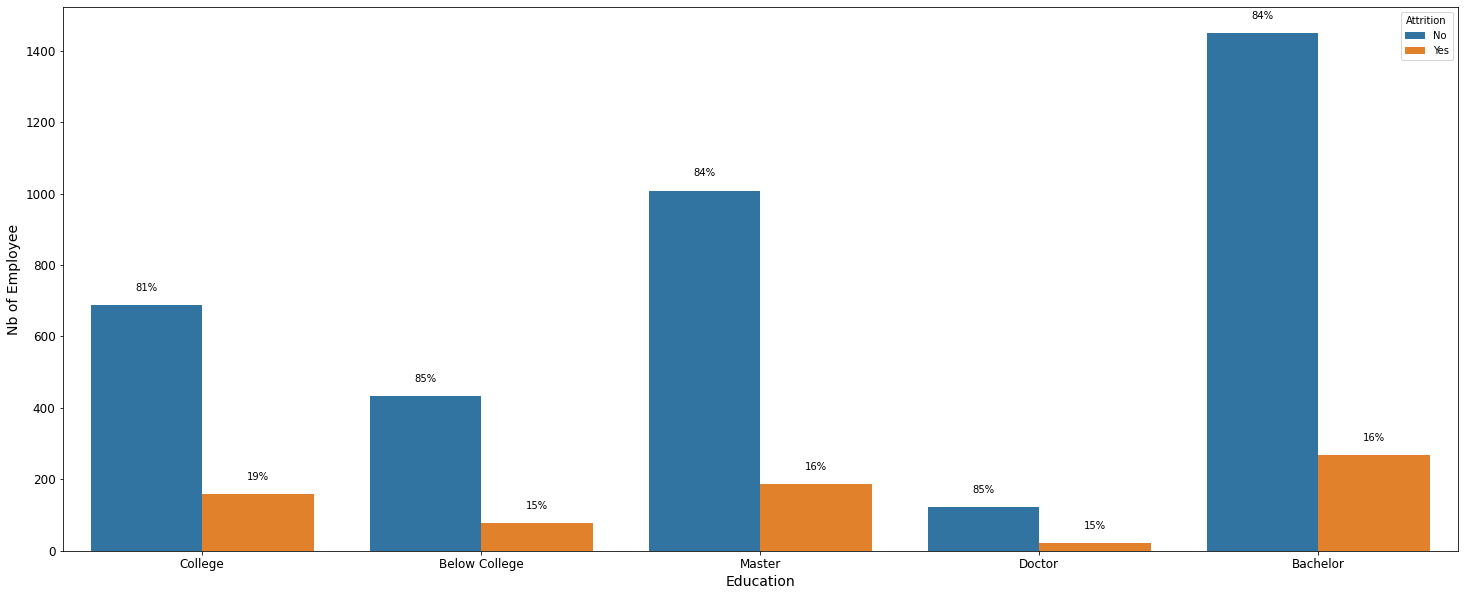

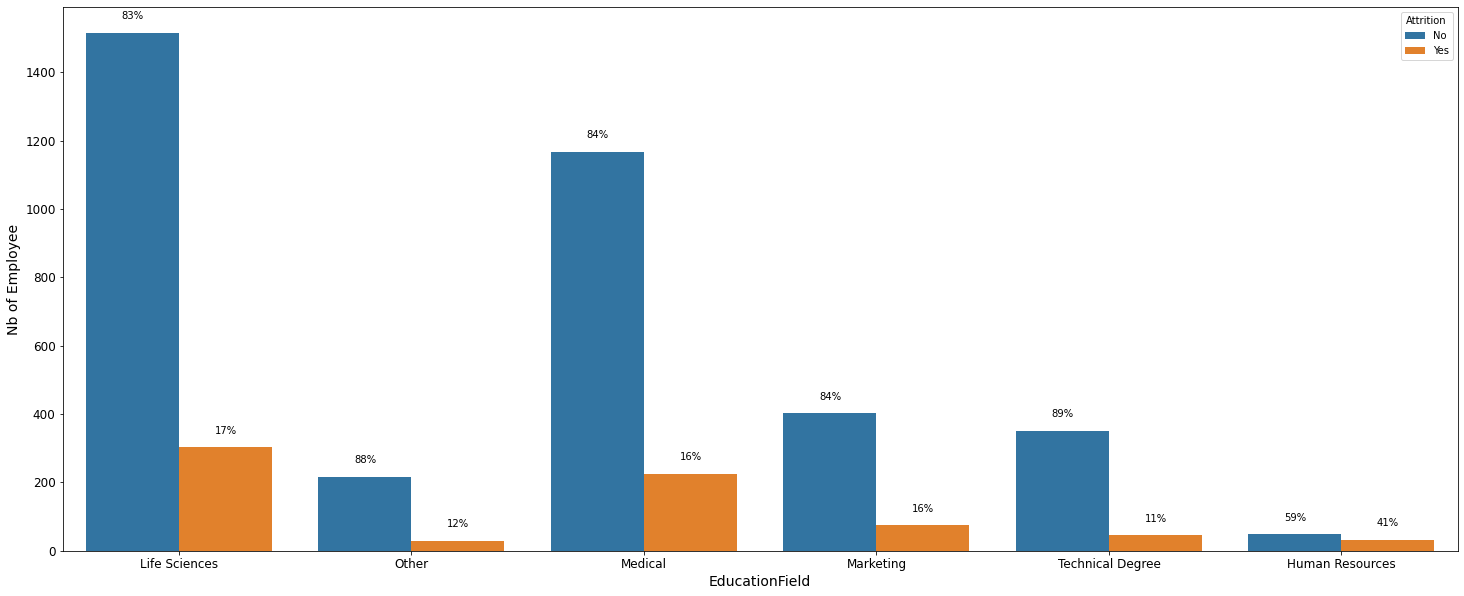

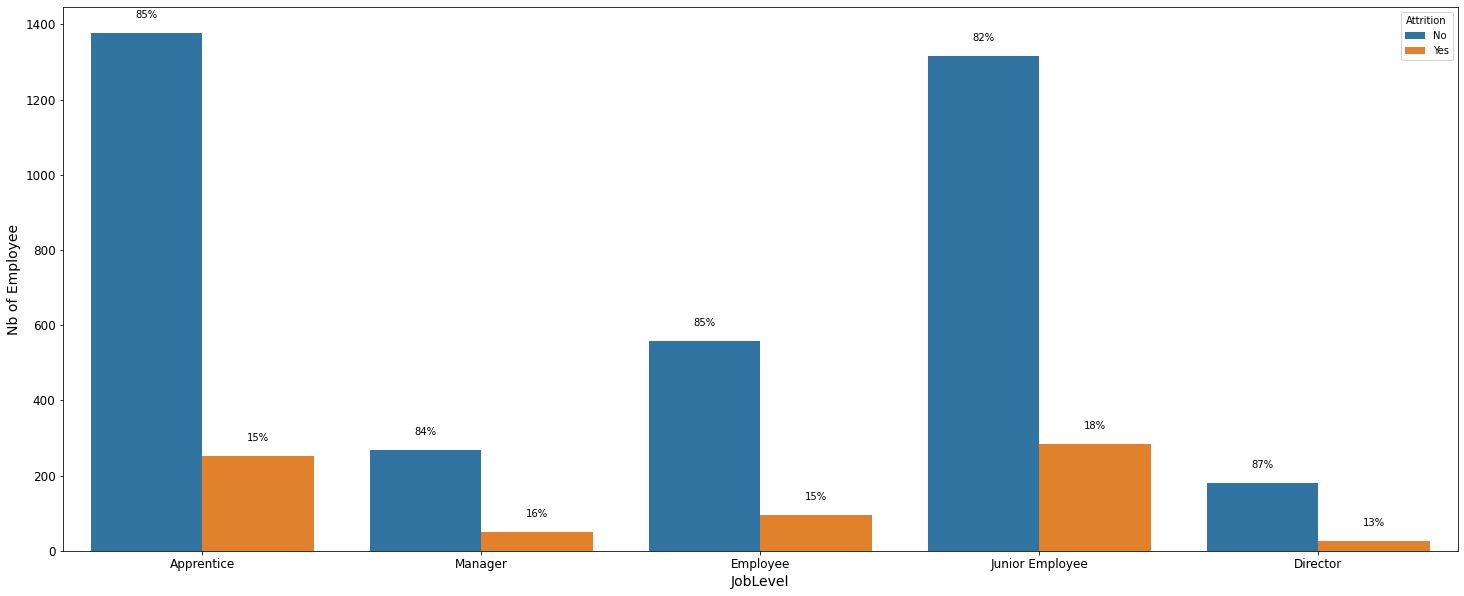

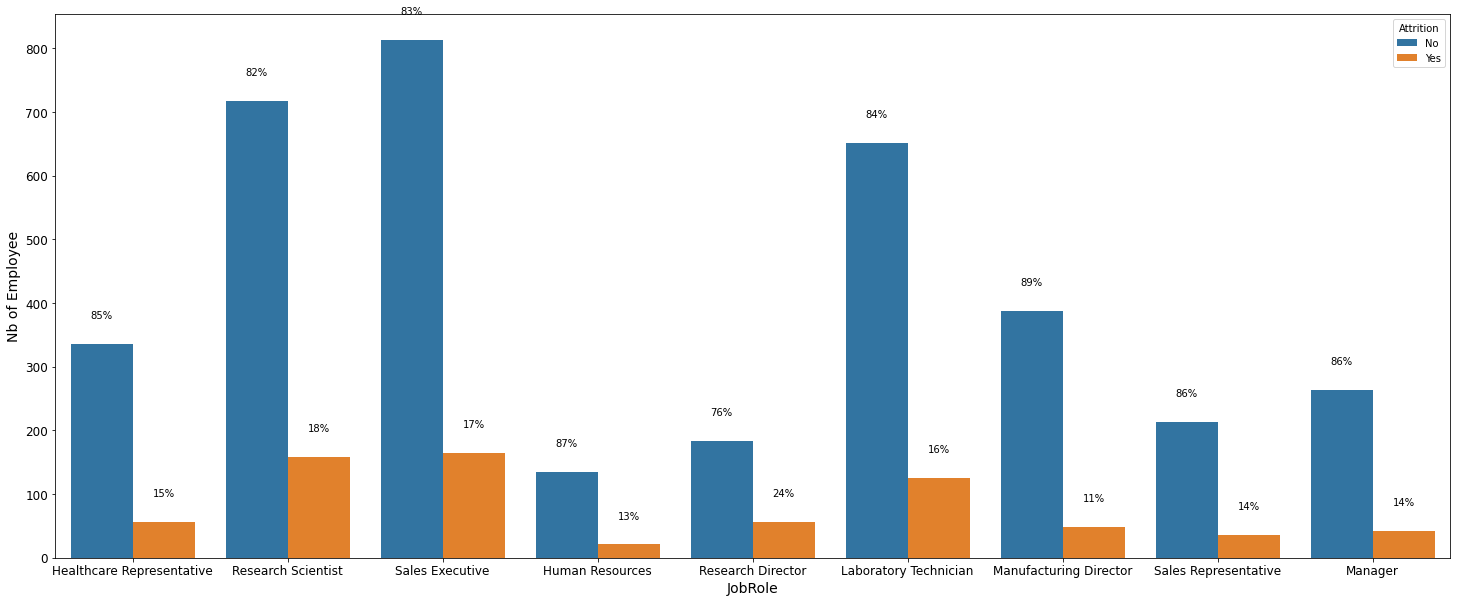

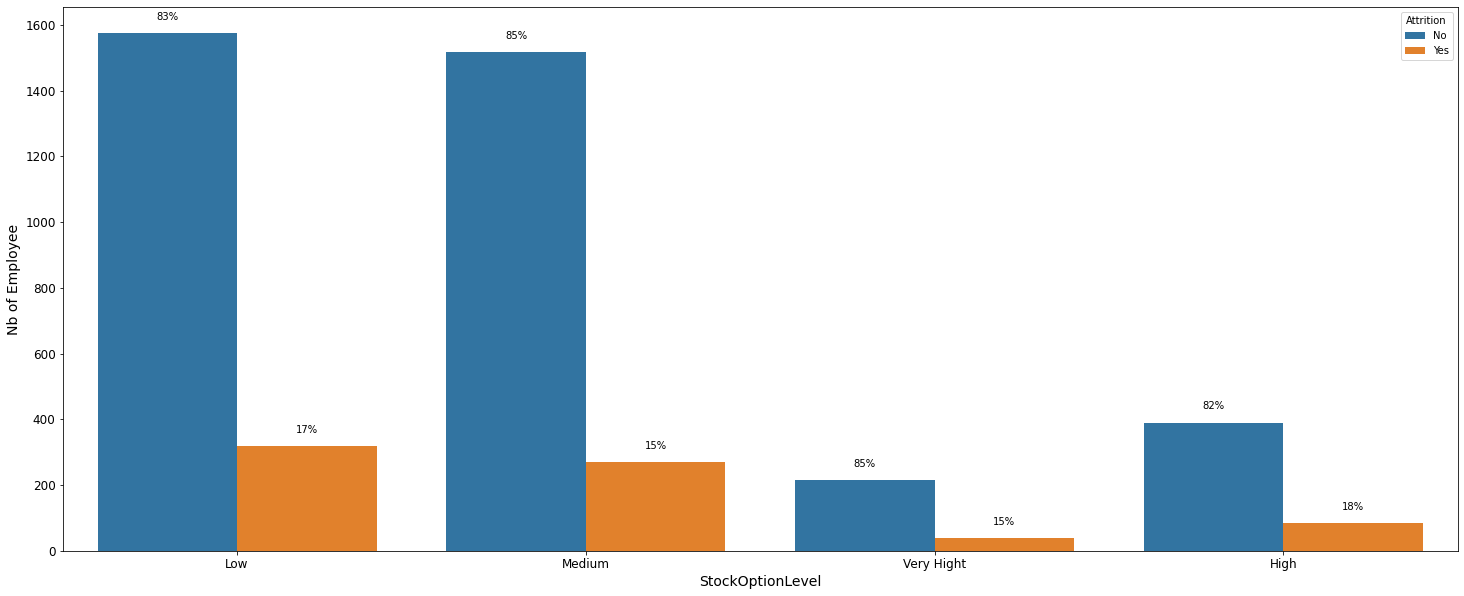

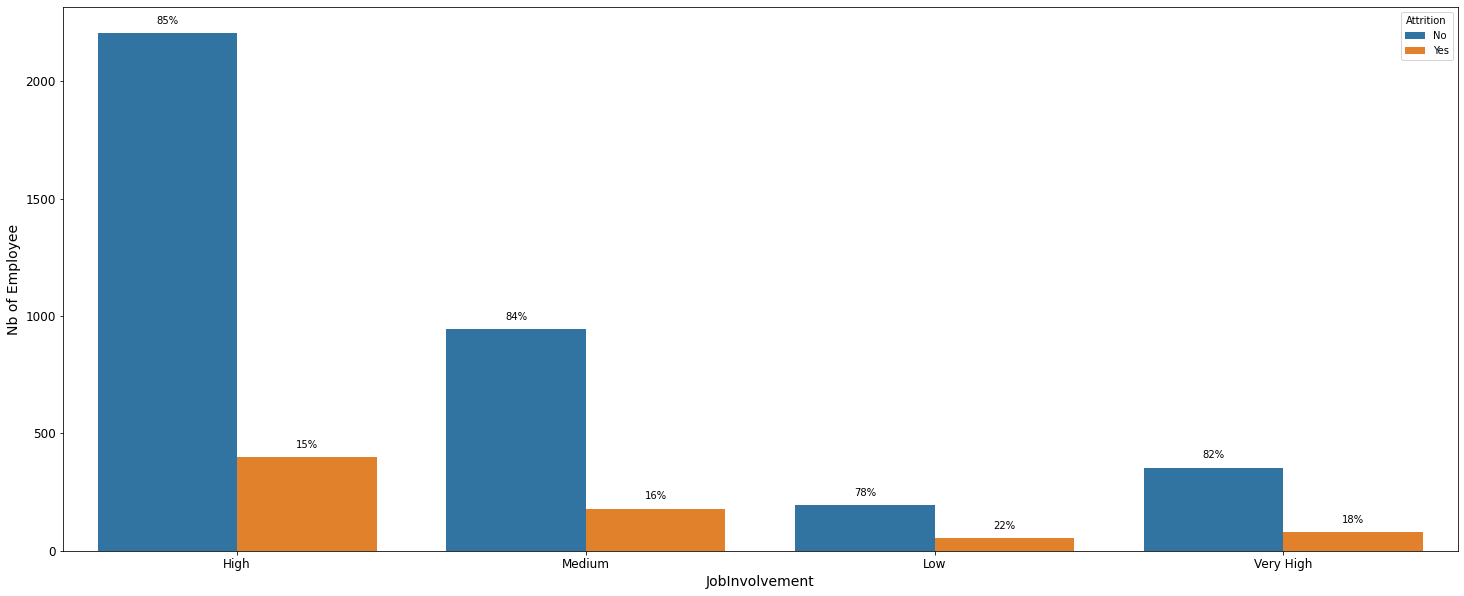

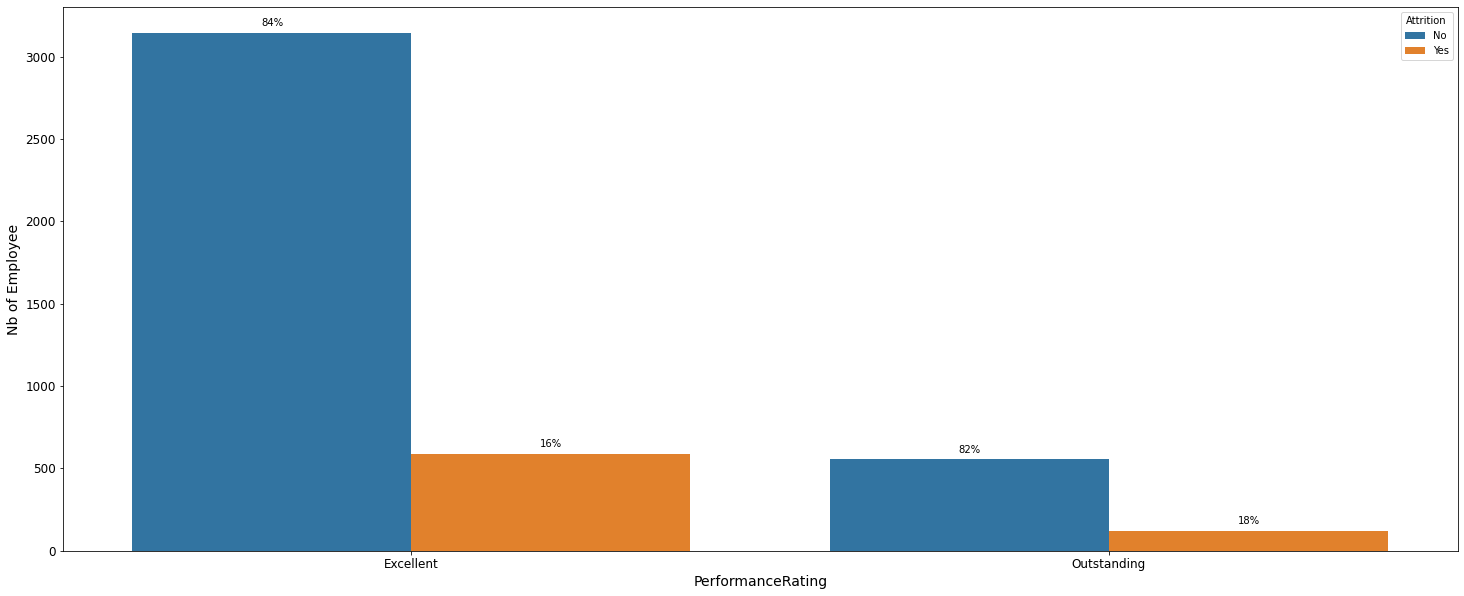

In [7]:
for name_column in allData.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        plt.figure(figsize=(25,10))
        ax = sns.countplot(x=name_column, data=allData, hue="Attrition")
        ax.set_ylabel('Nb of Employee')
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

#### Analyse de toutes les variables quantitatives

Vous trouverez en dessous tous les graphes avec les variables de type `number` du jeu de données.

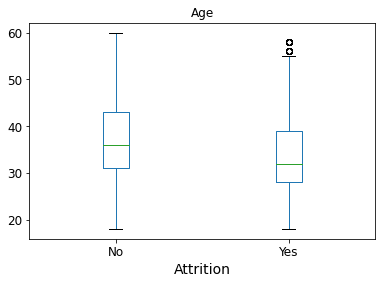

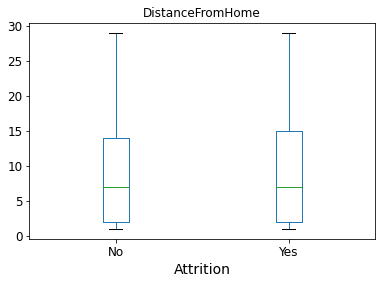

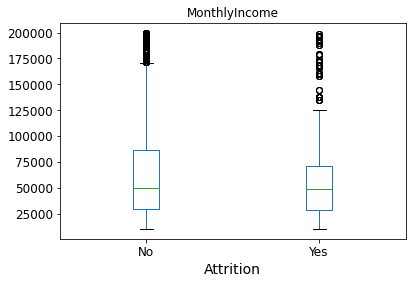

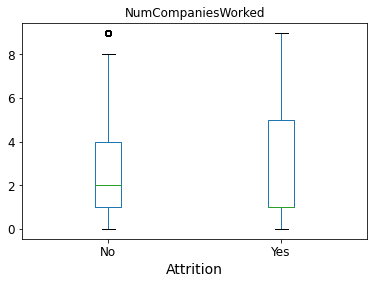

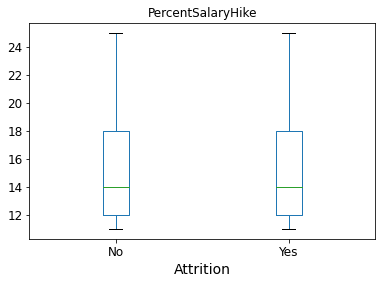

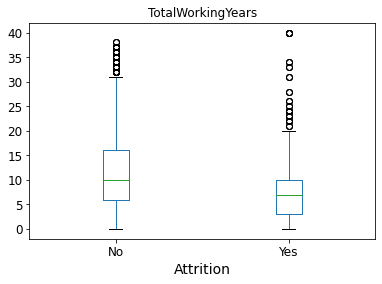

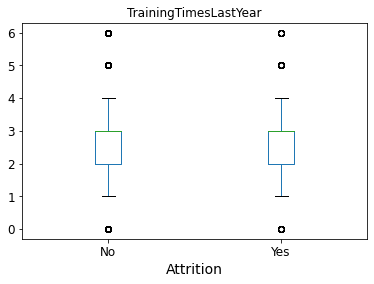

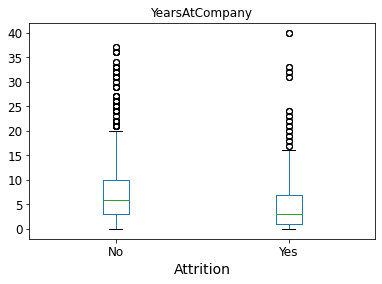

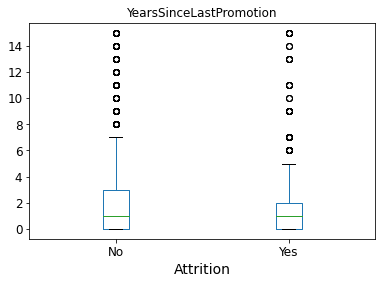

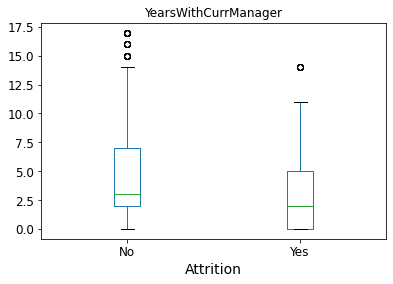

In [8]:
for name_column in allData.select_dtypes(np.number).columns:
    allData.boxplot(by ='Attrition', column = name_column, grid = False, figsize=None) 
    plt.suptitle("")

### B. Test des données

Nous allons utiliser deux tests différents afin de tester la dépendance de la variable attrition avec les autres. On utilise donc Anova lorsque la deuxième variable est quantitative et Khi2 lorsque la deuxième variable est qualitative. Ces tests nous renvoient deux données. La première est la valeur du test et la seconde est la p-value. Cette dernière nous permet d'évaluer la dépendance. Si la p-value est inférieur à 5%, cela veut dire que nous pouvons rejeter l'hypothèse d'indépendance et donc que l'attrition dépend de la variable  choisie.

#### Anova

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for name_column in allData.select_dtypes(include=np.number).columns:
    test_anova = name_column + ' ~ Attrition'
    model = ols(test_anova, data=allData).fit()
    result_anova = sm.stats.anova_lm(model, typ=2)
    print(name_column, "= F : ", result_anova["F"][0], ", p_value : ", result_anova["PR(>F)"][0], "\033[32mDépendant\033[0m" if result_anova["PR(>F)"][0] < 0.05 else "\033[31mIndépendant\033[0m")

Age = F :  114.63168185909241 , p_value :  1.996801615882959e-26 Dépendant
DistanceFromHome = F :  0.41736975384599256 , p_value :  0.5182860428065224 Indépendant
MonthlyIncome = F :  4.288570383801535 , p_value :  0.038427484905952394 Dépendant
NumCompaniesWorked = F :  7.884212755837695 , p_value :  0.0050088441899783275 Dépendant
PercentSalaryHike = F :  4.670236608422373 , p_value :  0.030743386433316814 Dépendant
TotalWorkingYears = F :  131.45193284104118 , p_value :  5.241246810650881e-30 Dépendant
TrainingTimesLastYear = F :  10.79680799832874 , p_value :  0.0010247061915349563 Dépendant
YearsAtCompany = F :  81.07844519572366 , p_value :  3.163883122481235e-19 Dépendant
YearsSinceLastPromotion = F :  4.811020933642654 , p_value :  0.02833033618936241 Dépendant
YearsWithCurrManager = F :  110.2369679679061 , p_value :  1.7339322652874626e-25 Dépendant


#### Khi2

In [10]:
import scipy.stats as stats


for name_column in allData.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        matrice = pd.crosstab(allData['Attrition'], allData[name_column])
        chi2, pvalue,dof, expected = stats.chi2_contingency(matrice)
        print(name_column, "= Statistics : ", chi2, ", p_value : ", pvalue, "\033[32mDépendant\033[0m" if pvalue < 0.05 else "\033[31mIndépendant\033[0m")

EnvironmentSatisfaction = Statistics :  65.20741335391335 , p_value :  4.5288923374665606e-14 Dépendant
JobSatisfaction = Statistics :  51.80338311883507 , p_value :  3.298455638541936e-11 Dépendant
WorkLifeBalance = Statistics :  48.97447919261813 , p_value :  1.3208783070533642e-10 Dépendant
BusinessTravel = Statistics :  72.54724105696552 , p_value :  1.764276972983189e-16 Dépendant
Department = Statistics :  29.090274924488266 , p_value :  4.820888218170406e-07 Dépendant
Education = Statistics :  5.641147679249198 , p_value :  0.2275982630178239 Indépendant
EducationField = Statistics :  46.194921001730584 , p_value :  8.288917469574179e-09 Dépendant
JobLevel = Statistics :  6.2691759264759925 , p_value :  0.1799276801337184 Indépendant
JobRole = Statistics :  25.116313674604072 , p_value :  0.001485544744815264 Dépendant
StockOptionLevel = Statistics :  3.046265305068262 , p_value :  0.38454683657380506 Indépendant
JobInvolvement = Statistics :  8.139110006255443 , p_value :  0.04

On peut donc constater que l'attrition est liée à de nombreuses variables

### C. Echantillonage stratifié



In [11]:
allDataForSplit = allData.copy()

X = allData.drop(['Attrition'], axis=1)
y = allData['Attrition'].copy()



In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=allData.Attrition)


## 3. Pipeline ML

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

dataNum = X_train.select_dtypes(include=[np.number])
dataCat = X_train.select_dtypes(exclude=[np.number])
num_attribs = list(dataNum)
cat_attribs = list(dataCat)
encoder = OneHotEncoder()

encoder.fit(dataCat)
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", encoder, cat_attribs),
    ])

data_X_train_prepared = full_pipeline.fit_transform(X_train)
data_X_train_prepared = pd.DataFrame(
    data_X_train_prepared,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(cat_attribs)))))

data_X_test_prepared = full_pipeline.fit_transform(X_test)
data_X_test_prepared = pd.DataFrame(
    data_X_test_prepared,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(cat_attribs)))))
data_X_test_prepared


,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,...,StockOptionLevel_High,StockOptionLevel_Low,StockOptionLevel_Medium,StockOptionLevel_Very Hight,JobInvolvement_High,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High,PerformanceRating_Excellent,PerformanceRating_Outstanding
0,0.541270,0.674418,-0.384014,2.464808,0.774646,-0.455933,-0.615877,-0.515020,-0.685844,-0.600576,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.581849,-0.895178,-0.739123,-0.689288,-1.140462,-0.193158,1.685832,0.491685,-0.685844,1.049605,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.368032,-0.532964,-0.800559,-0.689288,-0.866875,-0.850095,-0.615877,-0.347236,-0.685844,-0.325546,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.020289,-0.895178,-0.223453,1.676284,-0.046115,-0.455933,0.151360,-0.179452,-0.383990,-0.325546,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.204335,2.002538,-0.732805,-0.689288,1.321819,1.252102,1.685832,2.337313,-0.383990,0.499545,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,-0.132601,-1.015916,1.484991,-0.689288,-0.319702,0.463778,0.151360,1.330607,2.634543,1.874696,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1319,-1.929591,-0.412226,0.427290,-0.689288,0.501059,-1.244257,1.685832,-0.850589,-0.383990,-0.600576,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1320,-0.132601,1.398847,-0.893584,0.099236,-0.046115,-0.324546,-0.615877,-0.682805,-0.685844,-0.600576,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1321,-0.806472,-1.015916,2.395420,-0.295026,-0.866875,0.069616,-2.150349,0.491685,1.427130,-0.050516,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## 4. Modèle et performance

### A. Régression logistique

In [14]:
from sklearn.linear_model import LogisticRegression
X_train_lr = data_X_train_prepared.copy()
y_train_lr = (y_train.copy() == "Yes")
X_test_lr = data_X_test_prepared.copy()
y_test_lr = (y_test.copy() == "Yes")
lr = LogisticRegression(max_iter=500)
lr.fit(X=X_train_lr, y=y_train_lr)



LogisticRegression(max_iter=500)

In [15]:
import numpy
lr_pred = lr.predict(X_test_lr)

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(lr, X_train_lr, y_train_lr, cv=3, scoring="accuracy")

array([0.84645287, 0.85034014, 0.84062196])

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
print(metrics.classification_report(y_test_lr, lr_pred))

              precision    recall  f1-score   support

       False       0.86      0.98      0.91      1110
        True       0.59      0.16      0.26       213

    accuracy                           0.85      1323
   macro avg       0.73      0.57      0.59      1323
weighted avg       0.82      0.85      0.81      1323



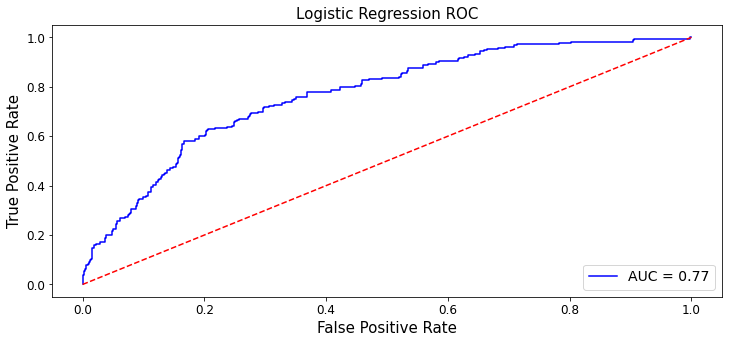

In [18]:

plt.figure(figsize=(12,5))

probaLr = lr.predict_proba(X_test_lr)
lr_pred = probaLr[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_lr, lr_pred, pos_label=lr.classes_[1])
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Logistic Regression ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

### B. Forêt aléatoire

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
X_train_forest = data_X_train_prepared.copy()
y_train_forest = (y_train.copy() == "Yes")
X_test_forest = data_X_test_prepared.copy()
y_test_forest = (y_test.copy() == "Yes")
forest_clf = RandomForestClassifier(random_state=42, n_estimators=200)
forest_clf.fit(X_train_forest,y_train_forest)

forest_pred=forest_clf.predict(X_test_forest)


In [20]:
print(metrics.classification_report(y_test_forest, forest_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1110
        True       1.00      0.93      0.96       213

    accuracy                           0.99      1323
   macro avg       0.99      0.96      0.98      1323
weighted avg       0.99      0.99      0.99      1323



In [21]:
cross_val_score(forest_clf, X_train_forest, y_train_forest, cv=3, scoring="accuracy")

array([0.9552964 , 0.96404276, 0.96695821])

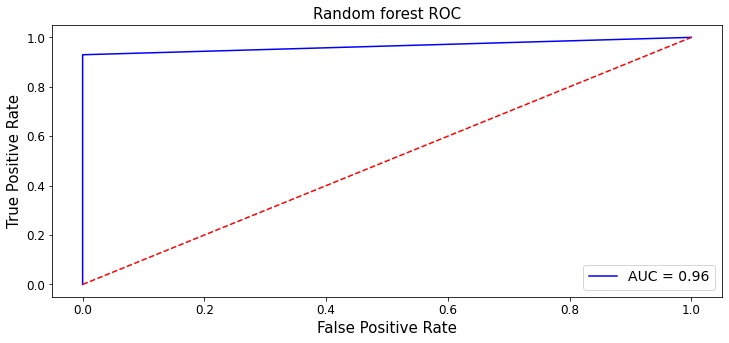

In [22]:
plt.figure(figsize=(12,5))

fpr, tpr, threshold = metrics.roc_curve(y_test_forest, forest_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Random forest ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

### C. Arbre de décision

<p>Implémentation de l'algorithme d'arbre de décision

In [23]:
from sklearn.tree import DecisionTreeClassifier
X_train_tree = data_X_train_prepared.copy()
y_train_tree = (y_train.copy() == "Yes")
X_test_tree = data_X_test_prepared.copy()
y_test_tree = (y_test.copy() == "Yes")
tree = DecisionTreeClassifier(min_samples_leaf=10)
tree = tree.fit(X_train_tree, y_train_tree)
tree.score(X_train_tree, y_train_tree)

0.9148040168448331

<p>Visualisation du graphique avec la librairie GraphViz

In [24]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="arbre.dot", filled=True, feature_names= X_train_tree.columns)

In [25]:
conda install python-graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [26]:
!dot -Tpng arbre.dot -o arbre.png

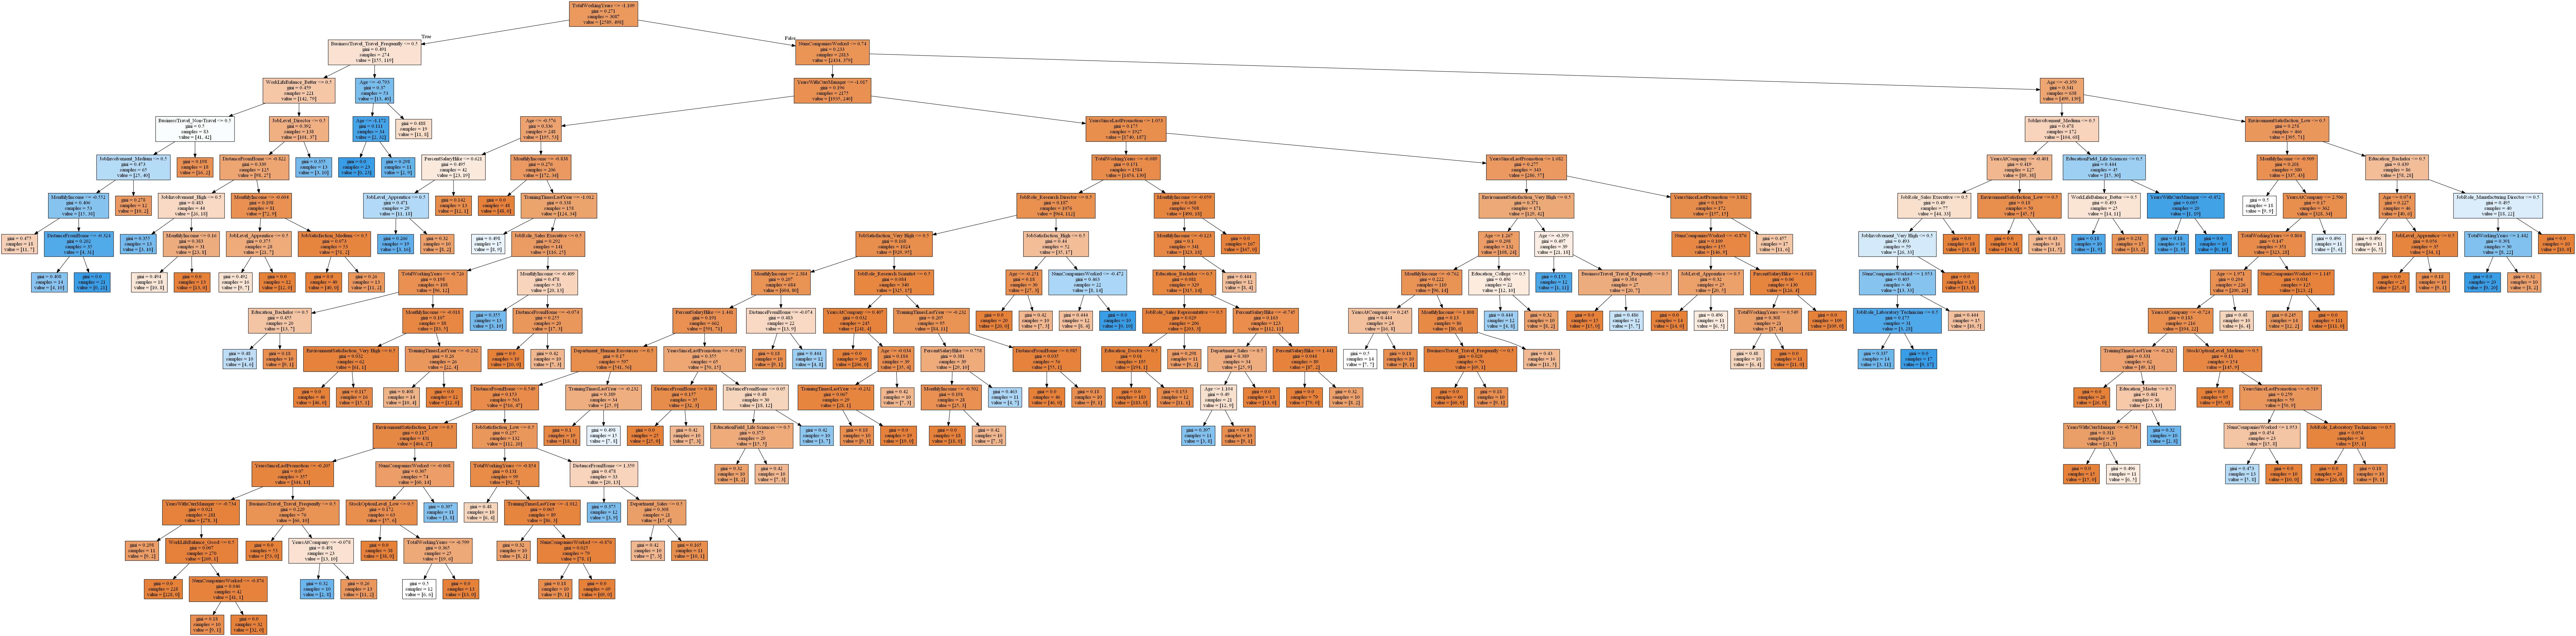

In [27]:
from IPython.core.display import Image
Image("arbre.png")

<p>Cross validation

In [28]:
tree_train_pred = tree.predict(X_test_lr)

In [29]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree, X_train_tree, y_train_tree, cv=3, scoring="accuracy")

array([0.84450923, 0.8425656 , 0.85325559])

<p>Matrice de confusion

In [30]:
confusion_matrix(y_test_tree, tree_train_pred)

array([[1037,   73],
       [ 119,   94]], dtype=int64)

<p>Rapport de la classification

In [31]:
print(metrics.classification_report(y_test_tree, tree_train_pred))

              precision    recall  f1-score   support

       False       0.90      0.93      0.92      1110
        True       0.56      0.44      0.49       213

    accuracy                           0.85      1323
   macro avg       0.73      0.69      0.71      1323
weighted avg       0.84      0.85      0.85      1323



<p>Création de la courbre ROC

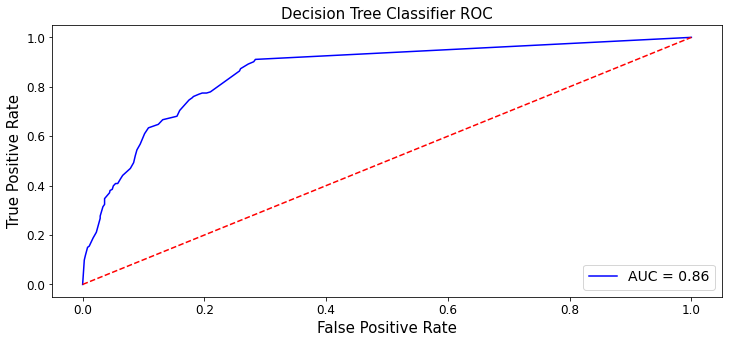

In [32]:
plt.figure(figsize=(12,5))

probaTree = tree.predict_proba(X_test_tree)
tree_test_pred = probaTree[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_tree, tree_test_pred, pos_label=tree.classes_[1])
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Decision Tree Classifier ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

### D. SVC (Support Vector Classifier) 

<p>Implémentation de l'algorithme Support Vector Classifier

In [33]:
from sklearn import svm

sv = svm.SVC(kernel='rbf', probability=True) #Create a svm Classifier
X_train_svc = data_X_train_prepared.copy()
y_train_svc = y_train.copy()
X_test_svc = data_X_test_prepared.copy()
y_test_svc = y_test.copy()
sv.fit(data_X_train_prepared, y_train)

svc_pred = sv.predict(X_test_svc)

<p>Matrice de confusion

In [34]:
confusion_matrix(y_test_svc, svc_pred)

array([[1107,    3],
       [ 135,   78]], dtype=int64)

<p>Rapport de la classification

In [35]:
print(metrics.classification_report(y_test_svc, svc_pred))


              precision    recall  f1-score   support

          No       0.89      1.00      0.94      1110
         Yes       0.96      0.37      0.53       213

    accuracy                           0.90      1323
   macro avg       0.93      0.68      0.74      1323
weighted avg       0.90      0.90      0.88      1323



<p>Création de la courbre ROC

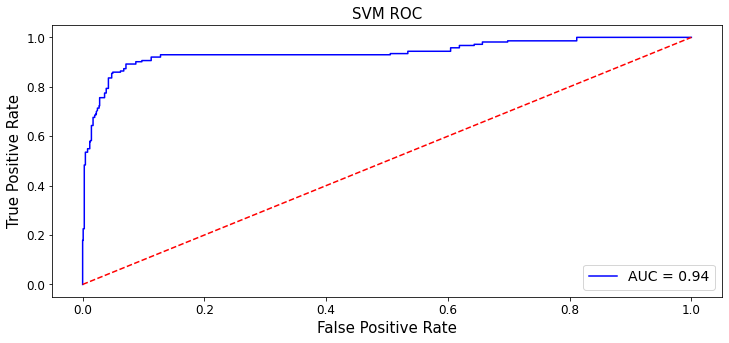

In [36]:
plt.figure(figsize=(12,5))

probaSVC = sv.predict_proba(X_test_svc)
svc_pred = probaSVC[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_svc, svc_pred, pos_label=sv.classes_[1])
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('SVM ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

### E. Classements de tous les algorithmes

| Algorithmes | Valeur AUC          |
| ------- | ------------------ |
|   1. Random Forest   | 0.96 |
|   2. SVC   | 0.94 |
|   3. Arbre de décision  | 0.86 |
|  4. Régression Logistique  | 0.77  |

## Résultats